# Understanding and plotting the decay of operonic and non-operonic gene pairs as a function of phylogenetic distance
The idea is to compute a genetic distance between two species. This will be used in comparing the genomic FGOC 
score between two species. <br />
I am using a tree computed (from the living tree of life) and downloaded from [silva DB](http://www.arb-silva.de/projects/living-tree/). This contains a curated list of 16sRNA and 23sRNA from bacterial and archael species. The tree nodes have been collapsed to the species level. This means I will have to use the same distance metric when comparing it at a strain level. <br />
The metric for the distance between two species is going to be a patristic distance. I calculate the distance matrix from this tree. The computation is intensive and requires a lot of memory. The file used is calcGenetic.py. I performed this calculation in a different server and stored it as a massive flatfile in the format - BACTERIA-A BACTERIA-B distance <br />

I then calculate the gene order conservation score comparing operonic genes and not operonic genes as a function of phylogenetic distance <br />
pkl files generated are - 
<ol><li> eco_org2_dist.dict.pkl </li>
<li> bsu_org2_dist.dict.pkl </li>
<li> bsu_allBact.notOperonScores.dict.pkl </li>
<li> bsu_allBact.operonScores.dict.pkl </li>
<li> eco_allBact.notOperonScores.dict.pkl </li>
<li> eco_allBact.operonScores.dict.pkl </li>
</ol>

In [73]:
%reset
import os
import time                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
import pickle 

def loadPkl(fname):
    pklDir = '/home/jaggu/research/projectFiles/operons/pklFiles'
    f = os.path.join(pklDir,fname)
    db = pickle.load(open(f))
    return db

def savePkl(db,pklFname):
    pklDir = '/home/jaggu/research/projectFiles/operons/pklFiles'    
    f = os.path.join(pklDir,pklFname)
    pickle.dump(db,open(f,'w'))
    return 

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [124]:
cogPair_dict = loadPkl('cogPair_count.dict.pkl')
cog_locusTag_dict = loadPkl('cog_locusTag.dict.pkl')
locus_cog_dict = loadPkl('locus_cog.dict.pkl')
org_locusTagPair_dict = loadPkl('org_locusTagPair.dict.pkl')
#org_cogPair_dict = loadPkl('org_cogPair.dict.pkl')
sp_cogPair_dict = loadPkl('sp_cogPair.dict.pkl')
cogPair_fgocInfo_dict_sp = loadPkl('cogPair_fgocInfo.spp.dict.pkl')

print "Dictionaries loaded",time.ctime()

Dictionaries loaded Tue Dec 29 15:27:49 2015


In [22]:
# DICTIONARY FOR PATRISTIC DISTANCE
# Making a dictionary for (Org1,org2):dist where Org1 is either Escherichia or Bacillus etc.
import os
import cPickle as pickle

def savePkl(db,pklFname):
    pklDir = '/home/jaggu/research/projectFiles/operons/pklFiles'    
    f = os.path.join(pklDir,pklFname)
    pickle.dump(db,open(f,'w'))
    return 

bactTreeDir = '/home/jaggu/research/downloads/bacterialTrees/silvaDB'
distFile = 'all.bactDist.txt'
fname = os.path.join(bactTreeDir,distFile)
#org = 'eco'
#orgName = 'Escherichia coli'
org = 'bsu'
orgName = 'Bacillus subtilis'
orgDistDict = dict()

with open(fname) as f:
    for line in f:
        if not line.startswith('BACTERIA'):
            if line.startswith(orgName):
                newLine = line.replace(' ','_')
                org1,org2,dist = newLine.strip().split('\t')
                dist = float(dist)
                org1Name = org1.split('_')[0]+'_'+org1.split('_')[1]
                org2Name = org2.split('_')[0]+'_'+org2.split('_')[1]
                #print org1Name, org2Name, dist
                orgDistDict[org2Name]=dist
savePkl(orgDistDict,org+'_org2_dist.dict.pkl')
print org + " : Pickled"


bsuPickled


In [56]:
# Making dictionary of Accession number : Taxon ID; This is mappable using ncbi taxonomy
import os
import sys

sourceDir = '/home/jaggu/research/allGenomeRptFiles'
accNbr_taxID_dict = dict()
taxID_accNbr_dict = dict()

def getTaxonInfo(f):
    ifile = open(f,'r')
    lines = ifile.readlines()
    ifile.close()
    accNbr = os.path.split(f)[1][:-4]
    for line in lines:
        if line.startswith('GI'): gi = line.split(':')[1].strip()
        if line.startswith('Taxid'): taxid = line.split(':')[1].strip()
    return accNbr, gi, taxid
    

for root, dirname, files in os.walk(sourceDir):
    for f in files: 
        fpath = os.path.join(root,f)
        accNbr, gi, taxid = getTaxonInfo(fpath)
        accNbr_taxID_dict[accNbr]=taxid
        taxID_accNbr_dict[taxid]=accNbr

savePkl(accNbr_taxID_dict,'accNbr_taxID.dict.pkl')
savePkl(taxID_accNbr_dict,'taxID_accNbr.dict.pkl')

print "Dictionaries created"

Dictionaries created


In [125]:
# Operon Pairs from REGULONDB : Only for E.coli K 12
# Using regulonDB as the source of E.coli K 12 operon (downloaded on 23rd Dec 2015)
# The file is provided by gene name like trpL etc. Need to (a) Make all pairwise gene names from the regulonDB 
# that belongs to operon (i.e nbrgenes >2) and call this between operon _ regulonDB; 
# (b) Make a map between the gene name and blattner name from the .ptt file. In this file, look for pairs 
# (get orientation information) to make the bwOperon and wOperon dictionary (ltag1,ltag2) : (dirFGOC,FGOC)

def getOperonGenePairs():
    operondbDir = '/home/jaggu/research/downloads/operons_databases/regulonDB'
    fname = 'OperonSet.txt'
    ifile = open(os.path.join(operondbDir,fname))
    lines = ifile.readlines()
    ifile.close()
    
    def getPairs(orientation,allGenes):
        allGenes_rshift = allGenes[1:]
        allGenes_lshift = allGenes[:-1]
        allPairs = zip(allGenes_lshift,allGenes_rshift)
        return allPairs
    
    allPairs = list()
    for line in lines:
        if not line.startswith('#'):
            orientation, nbrGenes, allGeneNames = [line.strip().split('\t')[i] for i in (3,4,5)]
            if int(nbrGenes)>2:
                allGenes = allGeneNames.split(',')
                operonPairs = getPairs(orientation,allGenes)
                allPairs.extend(operonPairs)
    return allPairs

def get_bNbrDict(sourceDir,orgName):
    orgDir = os.path.join(sourceDir,orgName[0])
    orgPttFile = os.path.join(orgDir,orgName[1]+'.ptt') 
    ifile = open(orgPttFile,'r')
    lines = ifile.readlines()
    ifile.close()
    bNbr_info_dict = dict()

    for line in lines[3:]:
        orientation, geneName, bNbr = [line.rstrip().split('\t')[i] for i in (1,4,5)]
        bNbr_info_dict[bNbr]=(orientation,geneName)
    return bNbr_info_dict

def getCog(lTag):
    try:
        cog = locus_cog_dict[lTag]
    except KeyError:
        cog = 'nan'
    if cog == '-': cog = 'nan' #Some wierd bug
    return cog

def checkOperon(ltag1,ltag2,bNbr_info_dict,operonPairs_list):
    operon = False
    genePair = (ltag1,ltag2)
    dir1,name1 = bNbr_info_dict[ltag1]
    dir2,name2 = bNbr_info_dict[ltag2]
    if dir1 == dir2 == '+':
        genePair = (ltag1,ltag2)
        if (name1,name2) in operonPairs_list:
            operon = True
    elif dir1 == dir2 == '-':
        genePair = (ltag2,ltag1)
        if (name2,name1) in operonPairs_list:
            operon = True
    else:
        operon = False
        genePair = (ltag1,ltag2)
    return operon, genePair

def get_OperonPairs_COGList(operonPairs_regulonDB):
    # The function is mainly copied from the operonStats function. But it is changed to reflect getting the COG pairs
    # that makes the operon and between operon pairs
    # This is different from getting an dfgoc and fgoc score for the operon pairs; I make a list of the COG pairs
    wOp_COGList = list()
    bwOp_COGList = list()
    
    sourceDir = '/home/jaggu/research/allGenomePttFiles'
    org = 'eco' 
    orgName = ('Escherichia_coli_K_12_substr__MG1655_uid57779','NC_000913')
    allLocusTagPairs = org_locusTagPair_dict[orgName]

    bNbr_info_dict = get_bNbrDict(sourceDir,orgName)

    for (ltag1, ltag2) in allLocusTagPairs:
        operon, genePair = checkOperon(ltag1,ltag2,bNbr_info_dict,operonPairs_regulonDB)
        # genePair reorganizes the ltag pairs according to the orientation. 
        cogA,cogB = getCog(genePair[0]), getCog(genePair[1])
        if not (cogA is 'nan' or cogB is 'nan'):
            if operon:
                wOp_COGList.append((cogA,cogB))
            else:
                bwOp_COGList.append((cogA,cogB))

    return wOp_COGList, bwOp_COGList

operonPairs_regulonDB = getOperonGenePairs()
wOp_COGList_rdb, bwOp_COGList_rdb = get_OperonPairs_COGList(operonPairs_regulonDB)
print len(wOp_COGList_rdb)
print len(bwOp_COGList_rdb)

savePkl(wOp_COGList_rdb,'eco_wOp_COGPairs.regulonDB.sp.list.pkl')
savePkl(bwOp_COGList_rdb,'eco_bwOp_COGPairs.regulonDB.sp.list.pkl')

print "At ",time.ctime()
print "Operonic gene pairs from regulonDB",len(operonPairs_regulonDB)
print "COGpair list of operon gene pairs (mapped to COG; regulonDB)  : %d"%(len(wOp_COGList_rdb))
print "COGpair list of between operon gene pairs (mapped to COG; regulonDB) : %d"%(len(bwOp_COGList_rdb))

1050
1197
At  Tue Dec 29 15:28:40 2015
Operonic gene pairs from regulonDB 1457
COGpair list of operon gene pairs (mapped to COG; regulonDB)  : 1050
COGpair list of between operon gene pairs (mapped to COG; regulonDB) : 1197


In [3]:
# Operon Pairs from MicrobesOnline; Using this to make the operonic genes and non-operonic genes.
# Calculating genFGOC score by comparing gene pair between operonic genes and non-operonic genes. 

import os
import cPickle as pickle

operondbDir = '/home/jaggu/research/downloads/operons_databases/microbesOnline'
sourceDir = '/home/jaggu/research/allGenomePttFiles'

def getOrientation(orgPttFile):
    #Get orientation right
    ifile = open(orgPttFile,'r')
    lines = ifile.readlines()
    ifile.close()
    orientationDict = dict()

    for line in lines[3:]:
        orientation,lTag = line.split('\t')[1],line.split('\t')[5]
        orientationDict[lTag]=orientation
    return orientationDict

def getCog(lTag):
    try:
        cog = locus_cog_dict[lTag]
    except KeyError:
        cog = 'nan'
    if cog == '-': cog = 'nan' #Some wierd bug
    return cog

def getCOGpairInfo(orientationDict,lTag1,lTag2):
    cogA = getCog(lTag1)
    cogB = getCog(lTag2)
    if cogA is 'nan' or cogB is 'nan':
        return None
    else:
        # Check orientation
        orientationA = orientationDict[lTag1]
        orientationB = orientationDict[lTag2]
        if orientationA == orientationB == '+':
            cogPair = (cogA,cogB)
        elif orientationA == orientationB == '-':
            cogPair = (cogB,cogA)
        else:
            cogPair = (cogA,cogB)
    return cogPair

# THIS IS WHERE YOU SHOULD CHANGE THE organism 
#org = 'eco' 
#orgName = ('Escherichia_coli_K_12_substr__MG1655_uid57779','NC_000913')
#org = 'bsu'
#orgName = ('Bacillus_subtilis_168_uid57675', 'NC_000964')
    
wOp_COG_list = list()
bwOp_COG_list = list()
  
def makeOperonPairs(org,orgName):
    wOp_COG_list = list()
    bwOp_COG_list = list()
    orgDir = os.path.join(sourceDir,orgName[0])
    orgPttFile = os.path.join(orgDir,orgName[1]+'.ptt') 
    # Getting orientation for each locus tag
    orientationDict = getOrientation(orgPttFile)

    # Parsing operon file
    fname = org+'.'+'operon'
    ifile = open(os.path.join(operondbDir,fname))
    lines = ifile.readlines()
    ifile.close()

    for line in lines[1:]:
        lTag1, lTag2, bOp = '','',''
        cogPair = tuple()
        lTag1,lTag2,bOp = [line.split('\t')[i] for i in [2,3,6]]
        cogPair = getCOGpairInfo(orientationDict,lTag1,lTag2)
        if cogPair:
            if bOp == 'TRUE':
                wOp_COG_list.append(cogPair)
            else:
                bwOp_COG_list.append(cogPair)
    print "For organism : %s ; Operon list done (in COG)"%(org)
    return wOp_COG_list, bwOp_COG_list

eco_wOpPairs, eco_bwOpPairs = makeOperonPairs('eco',('Escherichia_coli_K_12_substr__MG1655_uid57779','NC_000913'))
bsu_wOpPairs, bsu_bwOpPairs = makeOperonPairs('bsu',('Bacillus_subtilis_168_uid57675', 'NC_000964'))

For organism : eco ; Operon list done (in COG)
For organism : bsu ; Operon list done (in COG)


In [41]:
# Parse through the cogPairs across orgs (or species collapsed) and ask for intersection of sets;
# Calculates the operon score and between each org (or collapsed spp) not operon score

from __future__ import division
import fnmatch
import cPickle as pickle
import collections

def locate(pattern, root=os.curdir):
    '''Locate all files matching supplied filename pattern in and
    below supplied root directory.'''
    allFiles = []
    for path, dirs, files in os.walk(os.path.abspath(root)):
        for filename in fnmatch.filter(files, pattern):
            allFiles.append(os.path.join(path,filename))
    return allFiles

def intersect(a,b):
    return list(set(a)&set(b))

def getPairs_list(cogPair_list):
    pair_list = list()
    for pair in cogPair_list:
        if not (pair[0] == '-' or pair[1] == '-'):
            pair_list.append(pair)
    if len(pair_list)>1: return pair_list
    else: return list()

def getOrgName(pttFile):
    accNbr = os.path.split(pttFile)[-1].split('.')[0]
    orgName = os.path.split(os.path.split(pttFile)[0])[1]
    return (orgName,accNbr)

def getScores(cogPair_list,wOp_COGList,bwOp_COGList):
    flag = True
    #cogPair_list = org_cogPair_dict[orgName]
    pair_list = getPairs_list(cogPair_list)
    if pair_list:flag = True
    else: flag = False
    org_opList = intersect(pair_list,wOp_COGList)
    org_notOpList = intersect(pair_list,bwOp_COGList)

    operonScore = len(org_opList)/len(wOp_COGList)
    notOperonScore = len(org_notOpList)/len(bwOp_COGList)
    return operonScore,notOperonScore,flag

pklPath = '/home/jaggu/research/projectFiles/operons/pklFiles'
sourceDir = '/home/jaggu/research/allGenomePttFiles'


def main(org='eco'):
    allOperonScore_dict = collections.defaultdict(list)
    allNotOperonScore_dict = collections.defaultdict(list)

    # Generating the operonScore and notOperon score with all bacterial species (collapsed)
    # Needs wOp_COGList_rdb and bwOp_COGList_rdb
    print "Comparing %s with all bacteria ...",org
    for sp,allPairs in sp_cogPair_dict.items():
        operonScore, notOperonScore, status = getScores(allPairs,wOp_COGList_rdb,bwOp_COGList_rdb)
        if status:
            allOperonScore_dict[sp].append(operonScore)
            allNotOperonScore_dict[sp].append(notOperonScore)
    
    fOp = org + '_allBact.sp.operonScores.dict.pkl'
    fNotOp = org + '_allBact.sp.notOperonScores.dict.pkl'
    savePkl(allOperonScore_dict,fOp)
    savePkl(allNotOperonScore_dict,fNotOp)
    print "Operon and not operon Scores pickled; (RegulonDB)"

    return True

def old_main():
    # Generating the operonScore and notOperonScore with all bacterial species
    print "Comparing %s with all bacteria ..."%(org)
    allPttFiles = locate('*.ptt',sourceDir)
    for pttFile in allPttFiles:
        #print "Parsing :  %s file ..."%(pttFile)
        compareOrg = getOrgName(pttFile)
        operonScore, notOperonScore,status = getScores(compareOrg) 
        #status variable makes sure there is atleast one gene assigned.         
        if status: 
            allOperonScore_dict[compareOrg[0]].append(operonScore)
            allNotOperonScore_dict[compareOrg[0]].append(notOperonScore)

    fOp = org + '_allBact.operonScores.dict.pkl'
    fNotOp = org + '_allBact.notOperonScores.dict.pkl'
    savePkl(allOperonScore_dict,fOp)
    savePkl(allNotOperonScore_dict,fNotOp)
    print "Operon and not operon Scores pickled"

        
def test_case():
    #org = ('Escherichia_coli_K_12_substr__MG1655_uid57779','NC_000913')
    #org = ('Bacillus_subtilis_168_uid57675', 'NC_000964')
    #org = ('Clostridium_perfringens_SM101_uid58117', 'NC_008264')
    org = ('Sphaerochaeta_pleomorpha_Grapes_uid82365','NC_016633')
    operonScore,notOperonScore,status = getScores(org)
    
    print org, operonScore, notOperonScore, status

#test_case()
main()


Comparing %s with all bacteria ... eco
Operon and not operon Scores pickled; (RegulonDB)


True

In [42]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [56]:
# Plotting the graph of Operon scores vs genetic distance (using regulonDB and collapsed species)

def map_operonScore_dist(org='eco'):
    fDist = org + '_org2_dist.dict.pkl'
    fOp = org + '_allBact.sp.operonScores.dict.pkl'
    fNotOp = org + '_allBact.sp.notOperonScores.dict.pkl'
    org_dist_dict = loadPkl(fDist)
    allOperonScore_dict = loadPkl(fOp)
    allNotOperonScore_dict = loadPkl(fNotOp)

    opScore_dist_list = list()
    notOpScore_dist_list = list()

    for orgName, operonScore in allOperonScore_dict.items():
        species = orgName.split('_')[0]+'_'+orgName.split('_')[1]
        notOperonScore = allNotOperonScore_dict[orgName]
        try:
            dist = org_dist_dict[species]
        except KeyError:
            continue;
        opScore_dist_list.append([max(operonScore),dist])
        notOpScore_dist_list.append([max(notOperonScore),dist])

    print "For %s : List of [operonScore,distance] and [notOperonScore, distance] calculated"%(org)
    return opScore_dist_list, notOpScore_dist_list

opScore_dist_list, notOpScore_dist_list = map_operonScore_dist()

For eco : List of [operonScore,distance] and [notOperonScore, distance] calculated


Organism : eco ...


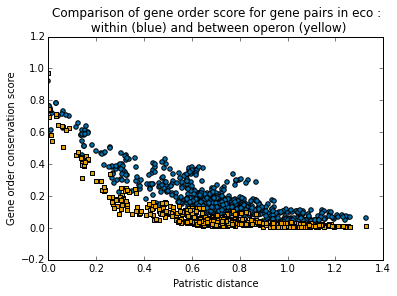

In [59]:
# Scatter plot between operon score and patristic distance

def drawScatter_operonScore_dist(opScore_dist_list, notOpScore_dist_list,org='eco'):
    imgDir = '/home/jaggu/research/projectFiles/operons/newFigures'

    % matplotlib inline
    import numpy as np
    import matplotlib.pyplot as plt

    print "Organism : %s ..."%(org) #Carrying over
    # For operon
    op_yVals = [item[0] for item in opScore_dist_list]
    op_dist = [item[1] for item in opScore_dist_list]

    notOp_yVals = [item[0] for item in notOpScore_dist_list]
    notOp_dist = [item[1] for item in notOpScore_dist_list]

    plt.scatter(op_dist,op_yVals,c='#0072b2',marker='o')
    plt.scatter(notOp_dist,notOp_yVals,c='#e69f00',marker='s')
    plt.xlim(xmin=0,xmax=1.4)
    plt.xlabel('Patristic distance')
    plt.ylabel('Gene order conservation score')
    plt.title('Comparison of gene order score for gene pairs in %s : \n within (blue) and between operon (yellow)'%(org))
    #plt.show()

    # Saving figure
    fname = org+'_OpBw_dist.scatter.svg'
    f = os.path.join(imgDir,fname)
    plt.savefig(f,dpi=300)
    
drawScatter_operonScore_dist(opScore_dist_list, notOpScore_dist_list)


***
# Distant COG pairs arising in the bacterial lineage

<body> It is not exactly oldest but most distant. But I want to ask, for the COG pair present in E.coli operon, which is the most distant bacteria where it is also found. A time line is a proxy with patristic distance. 
The hypothesis is more on the lines whether the COG pairs with high dfgoc score implies it was observed the earliest. Whether these are more prone to horizontal gene transfers or they are more conserved. </body>



In [127]:
%reset
import os
import pickle 
import time

def loadPkl(fname):
    pklDir = '/home/jaggu/research/projectFiles/operons/pklFiles'
    f = os.path.join(pklDir,fname)
    db = pickle.load(open(f))
    return db

def savePkl(db,pklFname):
    pklDir = '/home/jaggu/research/projectFiles/operons/pklFiles'    
    f = os.path.join(pklDir,pklFname)
    pickle.dump(db,open(f,'w'))
    return 

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [130]:
#cogPair_fgocInfo = loadPkl('cogPair_fgocInfo.dict.pkl')
cogPair_fgocInfo_dict_sp = loadPkl('cogPair_fgocInfo.spp.dict.pkl') #The cog is not 'nan' but '-'
sp_cogPair_dict = loadPkl('sp_cogPair.dict.pkl')
eco_wOp_COGPairs_rdb = loadPkl('eco_wOp_COGPairs.regulonDB.sp.list.pkl')
eco_bwOp_COGPairs_rdb = loadPkl('eco_bwOp_COGPairs.regulonDB.sp.list.pkl')

print "Dictionaries loaded : ",time.ctime()

Dictionaries loaded :  Tue Dec 29 15:31:56 2015


In [133]:
# Importing from 3rd cell for COG pairs within and between operons. Checking for E.coli first
# The eco_wOpPairs and eco_bwOpPairs list done; Now for bsu; 
# NOTE : Two list are needed for each organism - wOpPairs and bwOpPairs; These are not pickled and the list needs to be generated 
# before running this.

import collections
import time
import os
import cPickle as pickle
import sys

def getOp_bwOpPairs(org, org_wOpPairs,org_bwOpPairs, org_org2_dist_dict,sp_cogPair_dict):
    org_cogPair_allDist_dict = collections.defaultdict(list)
    org_cogPair_allDistSpp_dict = collections.defaultdict(list)
    org_cogPair_allDistNOTspp_dict = collections.defaultdict(list)
    for opPair in org_wOpPairs:
        for spName,cogPairList in sp_cogPair_dict.items():
            species = spName.split('_')[0]+'_'+spName.split('_')[1]
            try: 
                dist = org_org2_dist_dict[species]
            except KeyError:
                continue;
            if opPair in cogPairList:
                org_cogPair_allDist_dict[opPair].append(dist)
                org_cogPair_allDistSpp_dict[opPair].append((dist,species)) # COG pair present in species
            else:
                org_cogPair_allDistNOTspp_dict[opPair].append((dist,species)) #COG pair not present in species

    print "Completed within operon gene pairs"
    f1 = org + '_opPair_allDist.rdb.sp.dict.pkl'
    f1_spp = org + '_opPair_allDistSpp.rdb.sp.dict.pkl'
    f1_Notspp = org + '_opPair_allDistNOTSpp.rdb.sp.dict.pkl'
    savePkl(org_cogPair_allDist_dict,f1)
    savePkl(org_cogPair_allDistSpp_dict,f1_spp)
    savePkl(org_cogPair_allDistNOTspp_dict,f1_Notspp)

    org_cogPair_allDist_dict = collections.defaultdict(list)
    org_cogPair_allDistSpp_dict = collections.defaultdict(list)
    org_cogPair_allDistNOTspp_dict = collections.defaultdict(list)
    for opPair in org_bwOpPairs:
        for spName,cogPairList in sp_cogPair_dict.items():
            species = spName.split('_')[0]+'_'+spName.split('_')[1]
            try: 
                dist = org_org2_dist_dict[species]
            except KeyError:
                continue;
            if opPair in cogPairList:
                org_cogPair_allDist_dict[opPair].append(dist)
                org_cogPair_allDistSpp_dict[opPair].append((dist,species)) # COG pair present in species
            else:
                org_cogPair_allDistNOTspp_dict[opPair].append((dist,species)) #COG pair not present in species
    
    f2 = org + '_bwopPair_allDist.rdb.sp.dict.pkl'
    f2_spp = org + '_bwopPair_allDistSpp.rdb.sp.dict.pkl'
    f2_Notspp = org + '_bwopPair_allDistNOTSpp.rdb.sp.dict.pkl'
    savePkl(org_cogPair_allDist_dict,f2)
    savePkl(org_cogPair_allDistSpp_dict,f2_spp)
    savePkl(org_cogPair_allDistNOTspp_dict,f2_Notspp)
    return org, f1, f2

print "Loaded sp: cogPair ",len(sp_cogPair_dict.keys())

org = 'eco'
f = org + '_org2_dist.dict.pkl'
eco_org2_dist_dict = loadPkl(f)
org, f_wOpPair_dist, f_bwOpPair_dist = getOp_bwOpPairs(org,eco_wOp_COGPairs_rdb,eco_bwOp_COGPairs_rdb,eco_org2_dist_dict,sp_cogPair_dict)
print "Completed for organism ",org, f_wOpPair_dist, f_bwOpPair_dist

#org = 'bsu'
#f = org + '_org2_dist.dict.pkl'
#bsu_org2_dist_dict = loadPkl(f)
#prg, f_wOpPair_dist, f_bwOpPair_dist = getOp_bwOpPairs(org,bsu_wOpPairs,bsu_bwOpPairs,bsu_org2_dist_dict)
#print "Completed for organism ",org, f_wOpPair_dist, f_bwOpPair_dist


print "Completed at ",time.ctime()

Loaded sp: cogPair  1078
Completed within operon gene pairs
Completed for organism  eco eco_opPair_allDist.rdb.sp.dict.pkl eco_bwopPair_allDist.rdb.sp.dict.pkl
Completed at  Tue Dec 29 15:38:09 2015


In [274]:
import collections

def getMaxDistance_listCogPairs_dict(org):
    maxdist_opPairs_dict = collections.defaultdict(list)
    maxdist_bwopPairs_dict = collections.defaultdict(list)

    f1 = org + '_opPair_allDist.dict.pkl'
    f2 = org + '_bwopPair_allDist.dict.pkl'
    org_opPair_allDist_dict = loadPkl(f1)
    org_bwopPair_allDist_dict = loadPkl(f2)
   
    # Max distance for the COGPairs
    for cogPair, distL in org_opPair_allDist_dict.items():
        maxdist_opPairs_dict[round(max(distL),2)].append(cogPair)
    
    for cogPair, distL in org_bwopPair_allDist_dict.items():
        maxdist_bwopPairs_dict[round(max(distL),2)].append(cogPair)
    
    return maxdist_opPairs_dict, maxdist_bwopPairs_dict

eco_maxdist_opPairs_dict, eco_maxdist_bwopPairs_dict = getMaxDistance_listCogPairs_dict('eco')
bsu_maxdist_opPairs_dict, bsu_maxdist_bwopPairs_dict = getMaxDistance_listCogPairs_dict('bsu')
print len(eco_maxdist_opPairs_dict), len(eco_maxdist_bwopPairs_dict)
print len(bsu_maxdist_opPairs_dict), len(bsu_maxdist_bwopPairs_dict), bsu_maxdist_bwopPairs_dict.keys()[10]
print "Distance : List of CogPairs dictionary created for eco and bsu"

1292
751
1037
824
106 97
81 79 0.57
Distance : List of CogPairs dictionary created for eco and bsu


In [290]:
imgDir = '/home/jaggu/research/projectFiles/operons/figures'

% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def draw_maxDistance_nbrGenePairs(org, db1,db2):

    def getDistanceNbrGenePairs(db):
        xyList = list()
        for d in np.arange(0,1.5,0.01):
            try:
                cogPairs = db[d]
            except KeyError:
                cogPairs = []
            xyList.append((d,len(cogPairs)))
        xList, yList = zip(*xyList)
        return xList, yList

    xList,yList = getDistanceNbrGenePairs(db1)
    rects = plt.bar(xList, yList, width=0.01, color='#0072B2')

    plt.xlim([0,1.4])
    plt.xlabel('Patristic distance when Gene pair was first observed ')
    plt.ylabel('Number of gene pairs')
    plt.xticks(np.arange(0,1.4,0.1))
    plt.title('The most distant species where the ' + org + ' \n Operonic gene pairs occurred')
    #plt.show()
    # Saving figure
    fname = org + '_OpPairs_dist_occurrance.round2.bar.svg'
    f = os.path.join(imgDir,fname)
    print f
    plt.savefig(f,dpi=300)
    #plt.show()
    plt.close()

    xList,yList = getDistanceNbrGenePairs(db2)
    rects = plt.bar(xList, yList, width=0.01, color='#E69F00')
    plt.xlim([0,1.4])
    plt.xlabel('Patristic distance when Gene pair was first observed ')
    plt.ylabel('Number of gene pairs')
    plt.xticks(np.arange(0,1.4,0.1))
    plt.title('The most distant species where the ' + org + ' \n Non-Operonic gene pairs occurred')

    # Saving figure
    fname = org + '_bwOpPairs_dist_occurrance.round2.bar.svg'
    f = os.path.join(imgDir,fname)
    print f
    plt.savefig(f,dpi=300)
    #lt.show()
    plt.close()

    return True

draw_maxDistance_nbrGenePairs('eco',eco_maxdist_opPairs_dict, eco_maxdist_bwopPairs_dict)
draw_maxDistance_nbrGenePairs('bsu',bsu_maxdist_opPairs_dict, bsu_maxdist_bwopPairs_dict)


/home/jaggu/research/projectFiles/operons/figures/eco_OpPairs_dist_occurrance.round2.bar.svg
/home/jaggu/research/projectFiles/operons/figures/eco_bwOpPairs_dist_occurrance.round2.bar.svg
/home/jaggu/research/projectFiles/operons/figures/bsu_OpPairs_dist_occurrance.round2.bar.svg
/home/jaggu/research/projectFiles/operons/figures/bsu_bwOpPairs_dist_occurrance.round2.bar.svg


True

In [309]:
f2_spp = org + '_bwopPair_allDistSpp.rdb.sp.dict.pkl'# I want to see the taxonomic rank as a function of patristic distance; Importing ete2 and the ncbi; Copying functions
# from the drawingTree notebook
from __future__ import division
from ete2 import NCBITaxa, AttrFace, TreeStyle
import collections
ncbi = NCBITaxa()

# COPIED #
from itertools import groupby as g
def most_common_element(L):
    return max(g(sorted(L)), key=lambda(x, v):(len(list(v)),-L.index(x)))[0]
# END #

"""
def my_phyloTree(taxid_list,rank_limit=None):
    taxid2name = ncbi.get_taxid_translator(taxid_list)
    tree = ncbi.get_topology(taxid_list,rank_limit=rank_limit,collapse_subspecies=False)
    return tree

def my_layout(node):
    if getattr(node, "rank", None):
        rank_face = AttrFace("sci_name", fsize=12, fgcolor="#d55e00")
        node.add_face(rank_face, column=0, position="branch-top")
    if node.is_leaf():
        sciname_face = AttrFace("sci_name", fsize=12, fgcolor="#0072B2")
        node.add_face(sciname_face, column=0, position="branch-right")
"""

def getAllTaxID():
    allStrains_dir = '/home/jaggu/research/allGenomePttFiles'
    allTaxID = list()
    for path, dirnames, files in os.walk(allStrains_dir):
        for f in files:
            accNbr = os.path.split(f)[1][:-4]
            taxid = accNbr_taxID_dict.get(accNbr,None)
            allTaxID.append(taxid)
    return allTaxID

def populateRANK(allTaxID_list):
    allRANK_dict = collections.defaultdict(list)
    for taxid in allTaxID_list:
        lineage = ncbi.get_lineage(taxid)
        rank_dict = ncbi.get_rank(lineage)
        for rankID,rankName in rank_dict.items():
            allRANK_dict[rankName].append(rankID)
    return allRANK_dict


def get_maxOrgs_dist(org):
    bin_dist_name_dict = collections.defaultdict(list)
    # binning by rounding to 2 places
    allTaxID = getAllTaxID()
    allTaxID_list = list(set(allTaxID))
    print "Number of organisms (unique Taxon ID) : ",len(allTaxID_list)

    allRANK_dict = populateRANK(allTaxID_list)
    print allRANK_dict.keys()
    spp_taxid_orig = allRANK_dict['species'] 
    
    if org == 'eco': org_org2_dist_dict = eco_org2_dist_dict
    if org == 'bsu': org_org2_dist_dict = bsu_org2_dist_dict
    
    for orgName, dist in org_org2_dist_dict.items():
        name = orgName.replace('_',' ')
        name2taxid = ncbi.get_name_translator([name])
        if not name2taxid == {}:
            if not len(name2taxid[name])!=1 :
                [taxid] = name2taxid[name]
                d = round(dist,1)
                if taxid in spp_taxid_orig:
                    bin_dist_name_dict[d].append(taxid)
    return bin_dist_name_dict

def getXYList_names(bin_dist_name_dict):
    xNames = list()
    yList_big = list()
    yList_small = list()
    for d,taxid_list in sorted(bin_dist_name_dict.items()):
        d_dict = populateRANK(taxid_list)
        genus_list = d_dict['genus']
        class_list = d_dict['class']
        phylum_list = d_dict['phylum']
        name_genus_list = ncbi.translate_to_names(genus_list)
        name_class_list = ncbi.translate_to_names(class_list)
        name_phylum_list = ncbi.translate_to_names(phylum_list)
    
        common_genus = most_common_element(name_genus_list)
        nbr_common_genus = name_genus_list.count(common_genus)
        xNames.append(common_genus)
        yList_big.append(len(taxid_list))
        yList_small.append(nbr_common_genus)
        print d, len(taxid_list), name_genus_list.count(common_genus), most_common_element(name_genus_list),\
        most_common_element(name_class_list), most_common_element(name_phylum_list)
    return xNames, yList_small, yList_big

def draw_barChart(xNames,yList_small,yList_big):
    # Drawing a stacked bar chart for each binned 
    width = 0.35   # the width of the bars: can also be len(x) sequence

    xList = np.arange(0,(len(xNames)/10),0.1)
    #xList = np.arange(0,len(xNames),0.1)

    p1 = plt.bar(xList, yList_big, width=0.1, color='#E69F00', alpha = 0.5)
    #p2 = plt.bar(xList, yList_small, width=0.1, color='#E69F00', alpha = 1)

    plt.xlabel('Patristic distance from E.coli')
    plt.ylabel('Number of organisms ')
    plt.xticks(xList+0.05, xNames, rotation='vertical')
    plt.xlim([0,1.4])
    plt.title('Number of organisms and most represented genus \n with increasing patristic distance from E.coli')

    # Saving figure
    fname = org + '_PatristicDistance_nbrOrgs_overlay_abundantGenus.bar.svg'
    f = os.path.join(imgDir,fname)
    print f
    plt.savefig(f,dpi=300)
    #plt.show()
    plt.close()

bin_dist_name_dict = get_maxOrgs_dist('eco')
xNames, yList_small,yList_big = getXYList_names(bin_dist_name_dict)
draw_barChart(xNames,yList_small,yList_big)
print "For eco, total number of organisms :",sum(yList_big)

bin_dist_name_dict = get_maxOrgs_dist('bsu')
xNames, yList_small,yList_big = getXYList_names(bin_dist_name_dict)
draw_barChart(xNames,yList_small,yList_big)
print "For bsu, total number of organisms :",sum(yList_big)


Number of organisms (unique Taxon ID) :  2741
[u'superkingdom', u'tribe', u'no rank', u'subfamily', u'subgenus', u'suborder', u'family', u'species subgroup', u'subclass', u'order', u'species group', u'phylum', u'subspecies', u'superphylum', u'species', u'subphylum', u'genus', u'class']
0.0 9 3 Shigella Gammaproteobacteria Proteobacteria
0.1 24 5 Serratia Gammaproteobacteria Proteobacteria
0.2 17 4 Aeromonas Gammaproteobacteria Proteobacteria
0.3 45 13 Shewanella Gammaproteobacteria Proteobacteria
0.4 39 6 Pseudomonas Gammaproteobacteria Proteobacteria
0.5 49 8 Pseudomonas Gammaproteobacteria Proteobacteria
0.6 184 15 Burkholderia Betaproteobacteria Proteobacteria
0.7 291 18 Bacillus Alphaproteobacteria Firmicutes
0.8 182 16 Corynebacterium Actinobacteria Actinobacteria
0.9 95 8 Lactobacillus Actinobacteria Bacteroidetes
1.0 74 13 Streptococcus Bacilli Euryarchaeota
1.1 68 11 Streptococcus Methanomicrobia Euryarchaeota
1.2 24 4 Bifidobacterium Halobacteria Euryarchaeota
1.3 5 1 Haloarcu

In [134]:
org = 'eco'

eco_wopPair_allDistSpp_dict = loadPkl('eco_opPair_allDistSpp.rdb.sp.dict.pkl')
eco_wopPair_allDistNOTspp_dict = loadPkl('eco_opPair_allDistNOTSpp.rdb.sp.dict.pkl')

eco_bwopPair_allDistSpp_dict = loadPkl('eco_bwopPair_allDistSpp.rdb.sp.dict.pkl')
eco_bwopPair_allDistNOTspp_dict = loadPkl('eco_bwopPair_allDistNOTSpp.rdb.sp.dict.pkl')

eco_wOp_COGPairs_rdb = loadPkl('eco_wOp_COGPairs.regulonDB.sp.list.pkl')
eco_bwOp_COGPairs_rdb = loadPkl('eco_bwOp_COGPairs.regulonDB.sp.list.pkl')
cogPair_fgocInfo_dict_sp = loadPkl('cogPair_fgocInfo.spp.dict.pkl') #The cog is not 'nan' but '-'

print "Dictionary loaded",time.ctime()

Dictionary loaded Tue Dec 29 15:44:23 2015


In [144]:
# I want to really get at whether this operon pairs can be tracked to horizontal gene transfer. 
# If the pair has high score and is in E.coli operon, was there a patristic distance where it was absent. 
from __future__ import division
import collections
import numpy as np

imgDir = '/home/jaggu/research/projectFiles/operons/newFigures'

% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

org = 'eco'

def distBin_sppList(distSpp_list):
    # Given a distance_spp list, bin them and give yList_spp, yList_nbr
    distBin_sppList_dict = collections.defaultdict(list)
    for d,spp in distSpp_list:
        distBin_sppList_dict[round(d,2)].append(spp)
    return distBin_sppList_dict

def get_distFreqCounts(db_spp, db_notspp):
    xList = list()
    yList = list()
    dist_freqCount_dict = dict()
    for d in np.arange(0,1.4,0.01):
        try:nbr_spp = len(db_spp[d])
        except KeyError: nbr_spp = 0
        try: nbr_notspp = len(db_notspp[d])
        except KeyError: nbr_notspp = 0
        
        try:freq = nbr_spp / (nbr_spp + nbr_notspp)
        except ZeroDivisionError:freq = float('NaN')
        dist_freqCount_dict[d]=freq
    
    return dist_freqCount_dict

def plot_cogPairTrace(cogPair,xList,yList,info,cogPair_fgocInfo_dict):
    info = cogPair_fgocInfo_dict[cogPair]
    count = info[2]
    dfgoc = info[3]
    # Plotting
    
    xList, yList= zip(*sorted(dist_freqCount_dict.items()))
    plt.plot(xList,yList,color='#0E3D59',lw=4)
    plt.ylim([0,1.5])
    plt.xlabel('Patristic distance')
    plt.ylabel('Frequency of conservation of gene pair')
    title_info = 'Conservation history of \n operonic gene pair - '+str(cogPair)\
                +'\n Count - '+str(count) \
                +'\n dFGOC - '+str(dfgoc)
    plt.title(title_info)
    
    # Saving figure
    consHistory_imgDir = '/home/jaggu/research/projectFiles/operons/figures/eco_operonPairs_conservationHistory'
    fname = org + '_cogPair-'+str(dfgoc)+'.'+str(count)+'.'+str(cogPair)+'.plot.svg'
    f = os.path.join(consHistory_imgDir,fname)
    plt.savefig(f,dpi=300)
    #plt.show()
    plt.close()
    return True

def consTrace(cogPair,distSpp_list, distNOTspp_list, cogPair_consTrace_dict, cogPair_fgocInfo_dict, plotTrace=False):
    db_spp = distBin_sppList(distSpp_list)
    db_notspp = distBin_sppList(distNOTspp_list)

    dist_freqCount_dict = get_distFreqCounts(db_spp, db_notspp)

    # info = [cogA,cogB,count,dirFGOC,fgoc,aNbr,bNbr]
    info = cogPair_fgocInfo_dict[cogPair]
    count = info[2]
    dfgoc = info[3]

    xList, yList= zip(*sorted(dist_freqCount_dict.items()))
    cogPair_consTrace_dict[cogPair] = (xList, yList)
    
    if plotTrace: plot_cogPairTrace(cogPair,xList,yList,info,cogPair_fgocInfo_dict)
    return xList, yList

cogPair_wOp_consTrace_dict = dict()

for cogPair in eco_wOp_COGPairs_rdb:
    distSpp_list = eco_wopPair_allDistSpp_dict[cogPair]
    distNOTspp_list = eco_wopPair_allDistNOTspp_dict[cogPair]
   
    xList,yList = consTrace(cogPair, distSpp_list, distNOTspp_list,cogPair_wOp_consTrace_dict, cogPair_fgocInfo_dict_sp)
    cogPair_wOp_consTrace_dict[cogPair] = (xList,yList)

savePkl(cogPair_wOp_consTrace_dict,'cogPair_wOp_conservationTrace.sp.dict.pkl') 
print len(cogPair_wOp_consTrace_dict)
print "Within operons done"

cogPair_bwOp_consTrace_dict = dict()

for cogPair in eco_bwOp_COGPairs_rdb:
    distSpp_list = eco_bwopPair_allDistSpp_dict[cogPair]
    distNOTspp_list = eco_bwopPair_allDistNOTspp_dict[cogPair]
    
    xList,yList = consTrace(cogPair,distSpp_list, distNOTspp_list, cogPair_bwOp_consTrace_dict, cogPair_fgocInfo_dict_sp)
    cogPair_bwOp_consTrace_dict[cogPair] = (xList,yList)
savePkl(cogPair_bwOp_consTrace_dict,'cogPair_bwOp_conservationTrace.sp.dict.pkl') 
print len(cogPair_bwOp_consTrace_dict)

print "Completed images ",time.ctime()
print "Pickled"

968
Within operons done
1163
Completed images  Tue Dec 29 15:52:10 2015
Pickled


In [160]:
# Instead of an image for each trace, I could make a heatmap and cluster them.
# The columns are the binned patristic distance
import pandas as pd
import scipy
import scipy.cluster.hierarchy as sch
imgDir = '/home/jaggu/research/projectFiles/operons/newFigures'
txtDir = '/home/jaggu/research/projectFiles/operons/textData'

def drawHeatMap_consTrace(cogPair_consTrace_dict,fname):

    row_labels = cogPair_consTrace_dict.keys() 
    col_labels = cogPair_consTrace_dict.values()[0][0]

    data = np.zeros((len(row_labels),len(col_labels)),dtype=float)

    for i, vals in enumerate(cogPair_consTrace_dict.values()):
        traceArray = vals[1]
        data[i]=traceArray

    # Convert nan to zero. Else it breaks plot
    where_are_NaNs = np.isnan(data)
    data[where_are_NaNs] = 0
    df = pd.DataFrame(data, index=row_labels,columns=col_labels)
    f = os.path.join(txtDir,fname[:-4]+'.tab')
    df.to_csv(f, sep='\t')
    
    # Compute and plot dendrogram.
    fig = plt.figure(figsize=(60,60))
    axd = fig.add_axes([0.09,0.1,0.2,0.6]) # x-pos, y-pos, width, height
    # Clustering this data by rows. 
    clusterMethod = 'single'
    row_clusters = sch.linkage(df, method=clusterMethod,metric='euclidean')
    # Dendrogram
    row_dendr = sch.dendrogram(row_clusters,orientation='right',labels=row_labels)
    # Row label 1, 2, distance, #members

    # reorder data with respect to clustering
    df_rowclust = df.ix[row_dendr['leaves'][::-1]]
    axd.set_xticks([])
    axd.set_yticks([])
    
    # remove axes spines from dendrogram
    for i in axd.spines.values():
           i.set_visible(False)
            
    # plot heatmap
    axm = fig.add_axes([0.26,0.1,0.6,0.6]) # x-pos, y-pos, width, height
    #axm = fig.add_axes([0,0,1,1])
    #cax = axm.matshow(df_rowclust, interpolation='nearest')
    cax = axm.matshow(df_rowclust, interpolation='nearest',cmap='YlGnBu')
    #cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='Blues')

    fig.colorbar(cax)
    axm.set_xticks(range(len(df_rowclust.columns)),minor=False)
    axm.set_xticks(np.arange(0,1.4,0.1))
    axm.yaxis.tick_right()
    axm.set_yticks(range(len(df_rowclust.index)),minor=False)
    axm.set_xticklabels(list(df_rowclust.columns),rotation='vertical',fontsize=8)
    axm.set_yticklabels(list(df_rowclust.index),fontsize=8)

    # Saving figure
    
    f = os.path.join(imgDir,fname)
    print f
    plt.savefig(f,dpi=300)
    #plt.show()
    plt.close()
    return True

cogPair_wOp_consTrace_dict = loadPkl('cogPair_wOp_conservationTrace.sp.dict.pkl') 
fname = 'eco_wOpPairs_consHist_clustered.sp.heatmap.svg'    
drawHeatMap_consTrace(cogPair_wOp_consTrace_dict,fname)

cogPair_bwOp_consTrace_dict = loadPkl('cogPair_bwOp_conservationTrace.sp.dict.pkl') 
fname = 'eco_bwOpPairs_consHist_clustered.sp.heatmap.svg'    
drawHeatMap_consTrace(cogPair_bwOp_consTrace_dict,fname)


/home/jaggu/research/projectFiles/operons/newFigures/eco_wOpPairs_consHist_clustered.sp.heatmap.svg
/home/jaggu/research/projectFiles/operons/newFigures/eco_bwOpPairs_consHist_clustered.sp.heatmap.svg


True

In [146]:
#cogPair_consTrace_dict = loadPkl('cogPair_conservationTrace.dict.pkl') 
#cogPair_fgocInfo = loadPkl('cogPair_fgocInfo.dict.pkl')

cogPair_wOp_consTrace_dict = loadPkl('cogPair_wOp_conservationTrace.sp.dict.pkl') 
cogPair_bwOp_consTrace_dict = loadPkl('cogPair_bwOp_conservationTrace.sp.dict.pkl') 
cogPair_fgocInfo_dict_sp = loadPkl('cogPair_fgocInfo.spp.dict.pkl') #The cog is not 'nan' but '-'

print "Dictionaries loaded",time.ctime()


Dictionaries loaded Tue Dec 29 15:53:51 2015


In [150]:
from __future__ import division
import collections
from operator import itemgetter
import numpy as np

% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

imgDir = '/home/jaggu/research/projectFiles/operons/newFigures'

def drawHeatMap_sorted_consTrace(cogPair_consTrace_dict,cogPair_fgocInfo,fname):
    print len(cogPair_consTrace_dict)

    allCogPairs = cogPair_consTrace_dict.keys()
    cogPairs_dfgoc_list = list()

    for cogPair in allCogPairs:
        cogA,cogB,count,dfgoc,fgoc,anbr,bnbr = cogPair_fgocInfo[cogPair]
        cogPairs_dfgoc_list.append(((cogPair),dfgoc))

    sorted_cogPairs = sorted(cogPairs_dfgoc_list,key=itemgetter(1))


    row_labels = [item[0] for item in sorted_cogPairs]
    col_labels = cogPair_consTrace_dict.values()[0][0]
    data = np.zeros((len(row_labels),len(col_labels)),dtype=float)
    
    for i, cogpair in enumerate(row_labels):
        traceArray = cogPair_consTrace_dict[cogpair][1]
        data[i]=traceArray

    # Convert nan to zero. Else it breaks plot
    where_are_NaNs = np.isnan(data)
    data[where_are_NaNs] = 0

    # Plot Heatmap
    fig = plt.figure(figsize=(40,10))
    cax = plt.matshow(data, interpolation='nearest',cmap='YlGnBu')
    plt.colorbar(cax)
    plt.xticks(range(0,len(col_labels),20),np.arange(0,1.4,0.2))
    plt.yticks([])
    #plt.yticks(range(len(row_labels)),row_labels, fontsize=4)
    
    # Saving figure
    f = os.path.join(imgDir,fname)
    print f
    plt.savefig(f,dpi=300)
    #plt.show()
    plt.close()

fname = 'eco_wOpPairs_consHist_sorted_dFGOC.sp.regulonDB.heatmap.svg'
drawHeatMap_sorted_consTrace(cogPair_wOp_consTrace_dict,cogPair_fgocInfo_dict_sp,fname)


fname = 'eco_bwOpPairs_consHist_sorted_dFGOC.sp.regulonDB.heatmap.svg'
drawHeatMap_sorted_consTrace(cogPair_bwOp_consTrace_dict,cogPair_fgocInfo_dict_sp,fname)


968
/home/jaggu/research/projectFiles/operons/newFigures/eco_wOpPairs_consHist_sorted_dFGOC.sp.regulonDB.heatmap.svg
1163
/home/jaggu/research/projectFiles/operons/newFigures/eco_bwOpPairs_consHist_sorted_dFGOC.sp.regulonDB.heatmap.svg


/home/jaggu/research/projectFiles/operons/figures/eco_wOpPairs_dist_mean_dFGOC.bar.svg


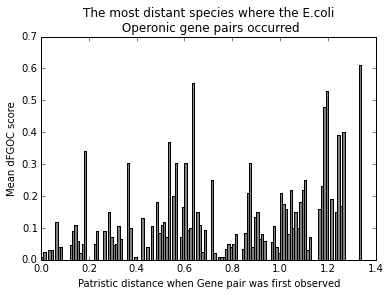

In [209]:
# Is the COG pairs arising in the most distant species, have a higher dfgoc score or lower? 

def getFGOC(cogPairsList):
    all_dfgoc = list()
    for cogPair in cogPairsList:
        # info = [cogA,cogB,count,dirFGOC,fgoc,aNbr,bNbr]
        info = cogPair_fgocInfo[cogPair]
        all_dfgoc.append(info[3])
       
    return np.median(all_dfgoc)

def getDistanceGenePairs(db):
    xyList = list()
    for d in np.arange(0,1.4,0.01):
        try:
            cogPairsList = db[d]
        except KeyError:
            cogPairsList = []
        if cogPairsList:
            mean_dfgoc = getFGOC(cogPairsList)
        else: mean_dfgoc = 0
        xyList.append((d,mean_dfgoc))
    xList, yList = zip(*xyList)
    return xList, yList

xList, yList = getDistanceGenePairs(dist_opPairs_dict)

rects = plt.bar(xList, yList, width=0.01, color='gray')

plt.xlim([0,1.4])
plt.xlabel('Patristic distance when Gene pair was first observed ')
plt.ylabel('Mean dFGOC score')
plt.title('The most distant species where the E.coli \n Operonic gene pairs occurred')

# Saving figure
fname = 'eco_wOpPairs_dist_mean_dFGOC.bar.svg'
f = os.path.join(imgDir,fname)
print f
plt.savefig(f,dpi=300)
plt.show()



In [86]:
# Custom checking the cogPairs

cog_func_dict = loadPkl('cogFunc.dict.pkl')

custom_cogPair_mostConsTrace = [
    ('COG1826','COG0805'),
    ('COG0755','COG3114'),
    ('COG2963','COG2801'),
    ('COG0094','COG0199'),
    ('COG0765','COG0765'),
    ('COG1173','COG0444'),
    ('COG0444','COG4608'),
    ('COG0257','COG0099')
]

custom_cogPair = [
    ('COG0619', 'COG1122'),
    ('COG3221', 'COG3638'), 
    ('COG0600', 'COG1116'), 
    ('COG3037', 'COG3414'), 
    ('COG0767', 'COG1127'),
    ('COG3396', 'COG3460'),
    ('COG3856', 'COG3879')]

for cogA, cogB in custom_cogPair:
    info = cogPair_fgocInfo[(cogA,cogB)]
    dfgoc = info[3]
    counts = info[2]
    print "\t".join([cogA, cogB, str(counts), str(dfgoc), cog_func_dict[cogA][1],\
                                 cog_func_dict[cogB][1], cog_func_dict[cogA][0],cog_func_dict[cogB][0]])

custom_cogPair_reversed = [reversed(item) for item in custom_cogPair]

print "*** REVERSED"
for cogA, cogB in custom_cogPair_reversed:
    info = cogPair_fgocInfo[(cogA,cogB)]
    dfgoc = info[3]
    counts = info[2]
    print "\t".join([cogA, cogB, str(counts), str(dfgoc), cog_func_dict[cogA][1],\
                                 cog_func_dict[cogB][1], cog_func_dict[cogA][0],cog_func_dict[cogB][0]])

print len(cog_func_dict)

COG0619	COG1122	562	0.3	Energy-coupling factor transporter transmembrane protein EcfT	Energy-coupling factor transporter ATP-binding protein EcfA2	H	PR
COG3221	COG3638	303	0.33	ABC-type phosphate/phosphonate transport system, periplasmic component	ABC-type phosphate/phosphonate transport system, ATPase component	P	P
COG0600	COG1116	1454	0.44	ABC-type nitrate/sulfonate/bicarbonate transport system, permease component	ABC-type nitrate/sulfonate/bicarbonate transport system, ATPase component	P	P
COG3037	COG3414	176	0.33	Ascorbate-specific PTS system EIIC-type component UlaA	Phosphotransferase system, galactitol-specific IIB component	G	G
COG0767	COG1127	616	0.4	ABC-type transporter Mla maintaining outer membrane lipid asymmetry, permease component MlaE	ABC-type transporter Mla maintaining outer membrane lipid asymmetry, ATPase component MlaF	M	M
COG3396	COG3460	227	0.39	1,2-phenylacetyl-CoA epoxidase, catalytic subunit	1,2-phenylacetyl-CoA epoxidase, PaaB subunit	Q	Q
COG3856	COG3879	107	0

In [317]:
# Details of the most common and distant COG pair; Can be copied-pasted to libreoffice
cog_func_dict = loadPkl('cogFunc.dict.pkl')

def output_COGFunction(db,cutoff):
    for dist, cogPairL in db.items():
        if dist > cutoff:
            for cogA,cogB in cogPairL: 
                info = cogPair_fgocInfo[(cogA,cogB)]
                dfgoc = info[3]
                counts = info[2]
                print "\t".join([cogA, cogB, str(counts), str(dfgoc), cog_func_dict[cogA][1],\
                                 cog_func_dict[cogB][1], cog_func_dict[cogA][0],cog_func_dict[cogB][0]])
    return True

print "Function for eco"
output_COGFunction(eco_maxdist_opPairs_dict,1.3)
print "**********************************"
print "**********************************"
print "Function for bsu"
output_COGFunction(bsu_maxdist_opPairs_dict,1.1)


COG4948	COG4948	108	0.04	L-alanine-DL-glutamate epimerase or related enzyme of enolase superfamily	L-alanine-DL-glutamate epimerase or related enzyme of enolase superfamily	MR	MR
COG1173	COG0444	2683	0.54	ABC-type dipeptide/oligopeptide/nickel transport system, permease component	ABC-type dipeptide/oligopeptide/nickel transport system, ATPase component	EP	EP
COG0444	COG4608	1269	0.32	ABC-type dipeptide/oligopeptide/nickel transport system, ATPase component	ABC-type oligopeptide transport system, ATPase component	EP	E
COG0094	COG0199	1334	0.9	Ribosomal protein L5	Ribosomal protein S14	J	J
COG1175	COG3833	562	0.1	ABC-type sugar transport system, permease component	ABC-type maltose transport system, permease component	G	G
COG0747	COG0601	3164	0.6	ABC-type transport system, periplasmic component	ABC-type dipeptide/oligopeptide/nickel transport system, permease component	E	EP
COG0091	COG0092	1458	0.99	Ribosomal protein L22	Ribosomal protein S3	J	J
COG0226	COG0573	1214	0.57	ABC-type phosphat

True